In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Update paths to the location in Drive
file1 = "/content/drive/MyDrive/quiz.json"
file2 = "/content/drive/MyDrive/Quizendpoint.json"
file3 = "/content/drive/MyDrive/apiendpoint.json"

Mounted at /content/drive


**DATA ANALYSIS**

In [3]:
import pandas as pd
import json
import os

# Load JSON data
with open(file1, 'r') as f:
    dataset1 = json.load(f)

with open(file2, 'r') as f:
    dataset1_quiz = json.load(f)

with open(file3, 'r') as f:
    dataset2 = json.load(f)

# Normalize datasets
df1 = pd.json_normalize(dataset1)  # Quiz data
#df1_quiz = pd.json_normalize(dataset1_quiz['quiz'], record_path=['questions'], meta=['id', 'title', 'topic'])  # Questions
# Normalize dataset1_quiz while avoiding conflicting column names
df1_quiz = pd.json_normalize(
    dataset1_quiz['quiz'],
    record_path=['questions'],
    meta=['id', 'title', 'topic'],
    meta_prefix='quiz_'  # Adding prefix to distinguish metadata fields
)

# Display the first few rows
print(df1_quiz.head())

df2 = pd.json_normalize(dataset2)  # User performance

'''# Display schema and first few rows
print("Quiz Data Schema:")
print(df1.info())

print("\nQuestions Data Schema:")
print(df1_quiz.info())

print("\nUser Performance Data Schema:")
print(df2.info())'''

# Preview Data
print(df1.head())
print(df1_quiz.head())
print(df2.head())



     id                                        description difficulty_level  \
0  1827  The tissue which has free surface that faces e...             None   
1  1828  Epithelial tissue is distinguished from connec...             None   
2  1829  The ciliated columnar epithelial cells in huma...             None   
3  1830                The squamous epithelium is found in             None   
4  1831  The kind of epithelium which forms the inner w...             None   

                                 topic  is_published  \
0  structural organisation in animals           True   
1  structural organisation in animals           True   
2  structural organisation in animals           True   
3  structural organisation in animals           True   
4  structural organisation in animals           True   

                      created_at                     updated_at  \
0  2024-07-02T12:43:34.360+05:30  2024-11-30T18:39:20.587+05:30   
1  2024-07-02T12:50:56.100+05:30  2024-11-30T18:39:20.

Here’s a refined and clearer assessment of the redundant values

---

### **1. `created_at`, `updated_at`**
- **Why redundant:** These fields track database events rather than user behavior or performance insights.
- **Justification:** The fields `submitted_at` and `started_at` already capture meaningful time-related information (such as quiz duration).

---

### **2. `banner_id`, `exam_id`, `coin_count`, `daily_date`, `live_count`**
- **Why redundant:** These fields seem linked to platform-specific features (e.g., UI banners or rewards).  
- **Justification:** They do not contribute to understanding student performance, trends, or recommendations.

---

### **3. `is_published`, `shuffle`, `show_answers`, `lock_solutions`, `is_form`, `show_mastery_option`, `show_unanswered`**
- **Why redundant:** These flags describe quiz settings but do not affect the student’s performance or learning outcomes.
- **Justification:** These are quiz properties rather than student-related data points.

---

### **4. `reading_material`, `description`, `name`, `quiz_type`, `language`, `photo_solution_url`, `photo_url`**  
- **Why redundant:** Placeholder fields or media URLs for quizzes and questions.
- **Justification:** They don’t offer value in evaluating performance insights or improvement recommendations.

---

### **5. `response_map`**
- **Why possibly redundant:** Detailed mapping of responses may be irrelevant unless analyzing specific question patterns.  
- **Justification:** If the focus is on aggregated insights rather than individual question analytics, this field can be ignored.

---

### **6. `id`, `rank_text`**  
- **Why redundant:** Technical database identifiers or formatted rank labels.
- **Justification:** Already covered by numeric rankings and scores.

---

### **Summary**
Removing these redundant fields simplifies your dataset by eliminating platform-specific noise, focusing solely on user actions and results (e.g., scores, accuracy, timestamps, topics).

In [4]:
import json
import pandas as pd
import numpy as np

# Load the JSON data
with open("/content/drive/MyDrive/apiendpoint.json", "r") as file1, \
     open("/content/drive/MyDrive/quiz.json", "r") as file2, \
     open("/content/drive/MyDrive/Quizendpoint.json", "r") as file3:
    data1 = json.load(file1)
    data2 = json.load(file2)
    data3 = json.load(file3)

# Combine all data entries
all_data = data1 + [data2] + [data3]

# Normalize the nested data into a DataFrame
df = pd.json_normalize(all_data, sep='_')

# Data Cleaning and Formatting
df['submitted_at'] = pd.to_datetime(df['submitted_at'], errors='coerce')
df['score'] = pd.to_numeric(df['score'], errors='coerce')
df['accuracy'] = df['accuracy'].str.rstrip(' %').astype('float')
df['correct_answers'] = pd.to_numeric(df['correct_answers'], errors='coerce')
df['incorrect_answers'] = pd.to_numeric(df['incorrect_answers'], errors='coerce')

# Estimate difficulty levels based on response accuracy
def estimate_difficulty(row):
    if row['accuracy'] >= 90:
        return 'Easy'
    elif 70 <= row['accuracy'] < 90:
        return 'Medium'
    else:
        return 'Hard'

# Apply difficulty estimation
df['difficulty_level'] = df.apply(estimate_difficulty, axis=1)

# Task: Generate Insights for Weak Areas, Improvement Trends, and Gaps
def generate_user_insights(user_id):
    user_data = df[df['user_id'] == user_id]
    if user_data.empty:
        return f"No data found for user: {user_id}"

    # Weak areas based on average score per topic
    weak_areas = user_data.groupby('quiz_topic')['score'].mean().nsmallest(3).index.tolist()

    # Improvement trends by chronological score order
    user_data = user_data.sort_values('submitted_at')
    improvement_trend = user_data['score'].pct_change().mean() * 100

    # Performance gaps
    missed_questions = user_data['total_questions'].sum() - user_data['correct_answers'].sum()

    # Insights on difficulty levels
    difficulty_insights = user_data.groupby('difficulty_level')['score'].mean().to_dict()

    insights = {
        'Weak Areas': weak_areas,
        'Improvement Trend (%)': improvement_trend,
        'Missed Questions': missed_questions,
        'Performance by Difficulty Level': difficulty_insights
    }
    return insights

# Define Student Persona
def define_student_persona(user_id):
    user_data = df[df['user_id'] == user_id]
    if user_data.empty:
        return f"No data found for user: {user_id}"

    strengths = []
    weaknesses = []

    # Identify strengths based on high scores and accuracy
    strong_topics = user_data.groupby('quiz_topic')['accuracy'].mean().nlargest(3).index.tolist()
    if strong_topics:
        strengths.append(f"Top Performing Topics: {', '.join(strong_topics)}")

    # Identify weaknesses based on low scores and high mistakes
    weak_topics = user_data.groupby('quiz_topic')['incorrect_answers'].mean().nlargest(3).index.tolist()
    if weak_topics:
        weaknesses.append(f"Topics with Most Mistakes: {', '.join(weak_topics)}")

    # Creative insights based on performance
    persona_label = "Persistent Learner" if user_data['score'].mean() < 50 else "Rising Star"

    persona = {
        'Persona Label': persona_label,
        'Strengths': strengths,
        'Weaknesses': weaknesses
    }

    return persona

# Task: Recommendations
def generate_recommendations(insights):
    recommendations = []

    # Focus on weak topics
    if insights['Weak Areas']:
        recommendations.append(f"Focus on the following weak topics: {', '.join(insights['Weak Areas'])}.")

    # Encourage maintaining or improving trends
    if insights['Improvement Trend (%)'] < 0:
        recommendations.append("Consider revisiting previous topics to improve your understanding.")
    else:
        recommendations.append("Great job on improving! Keep practicing to maintain this trend.")

    # Address performance gaps
    if insights['Missed Questions'] > 0:
        recommendations.append(f"You missed {insights['Missed Questions']} questions. Focus on accuracy and time management.")

    # Difficulty level-based suggestions
    if 'Hard' in insights['Performance by Difficulty Level']:
        recommendations.append("Spend more time on hard questions to improve your performance.")
    if 'Medium' in insights['Performance by Difficulty Level']:
        recommendations.append("Review medium-difficulty questions for a balanced improvement.")
    if 'Easy' in insights['Performance by Difficulty Level'] and insights['Performance by Difficulty Level']['Easy'] < 100:
        recommendations.append("Double-check answers on easy questions to avoid careless mistakes.")

    return recommendations

# Example Usage
user_id = "YcDFSO4ZukTJnnFMgRNVwZTE4j42"
insights = generate_user_insights(user_id)
recommendations = generate_recommendations(insights)
persona = define_student_persona(user_id)

# Clean and formatted output
print("\n===== User Insights =====")
for key, value in insights.items():
    print(f"{key}: {value}")

print("\n===== Recommendations =====")
for recommendation in recommendations:
    print(f"- {recommendation}")

print("\n===== Student Persona =====")
for key, value in persona.items():
    if isinstance(value, list):
        print(f"{key}: {', '.join(value)}")
    else:
        print(f"{key}: {value}")



===== User Insights =====
Weak Areas: ['principles of inheritance and variation ', 'Respiration and Gas Exchange', 'Human Reproduction']
Improvement Trend (%): 44.32941012698704
Missed Questions: 566.0
Performance by Difficulty Level: {'Easy': 82.85714285714286, 'Hard': 33.333333333333336, 'Medium': 64.0}

===== Recommendations =====
- Focus on the following weak topics: principles of inheritance and variation , Respiration and Gas Exchange, Human Reproduction.
- Great job on improving! Keep practicing to maintain this trend.
- You missed 566.0 questions. Focus on accuracy and time management.
- Spend more time on hard questions to improve your performance.
- Review medium-difficulty questions for a balanced improvement.
- Double-check answers on easy questions to avoid careless mistakes.

===== Student Persona =====
Persona Label: Rising Star
Strengths: Top Performing Topics: microbes in human welfare, human health and disease , reproductive health 
Weaknesses: Topics with Most Mista

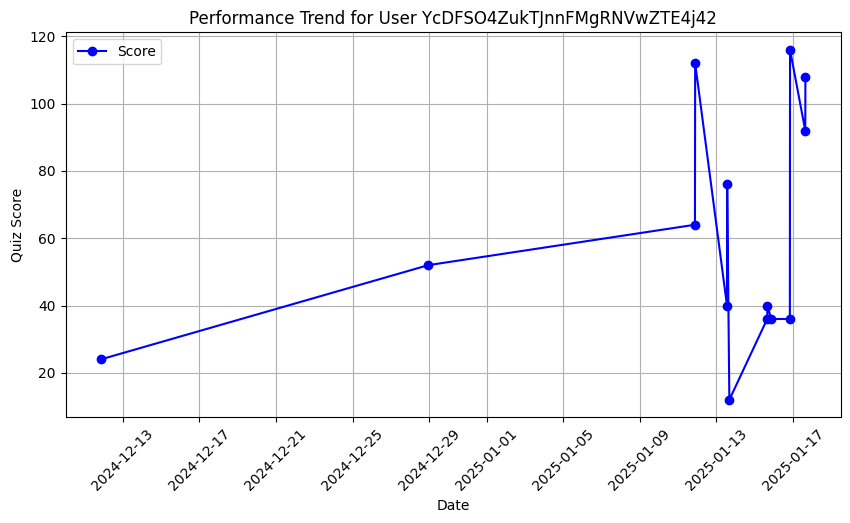

<ipython-input-7-07abbd6f8bc7>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_accuracy.index, y=topic_accuracy.values, palette='Reds_r')


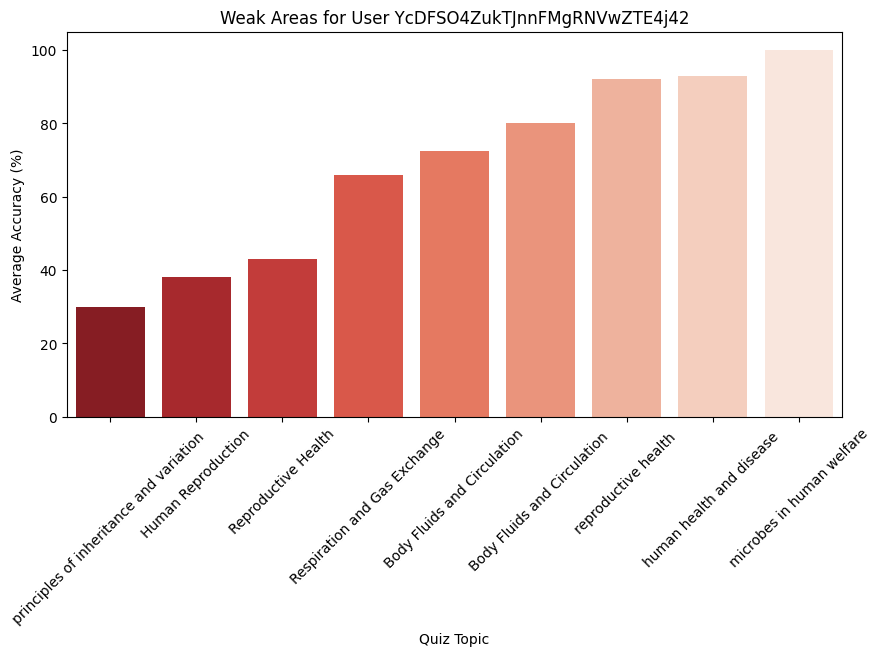

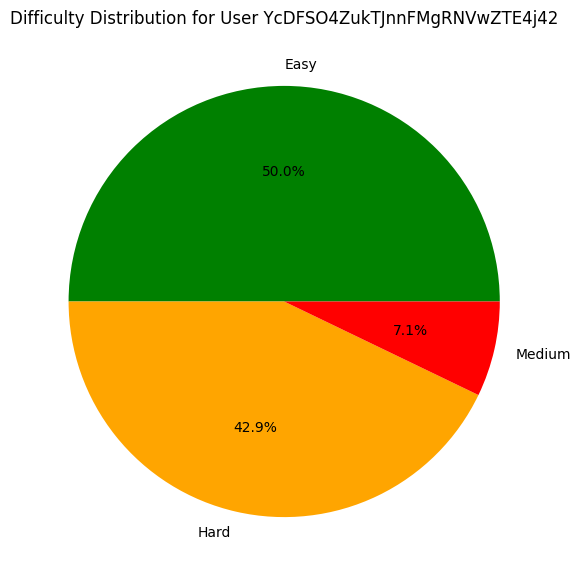

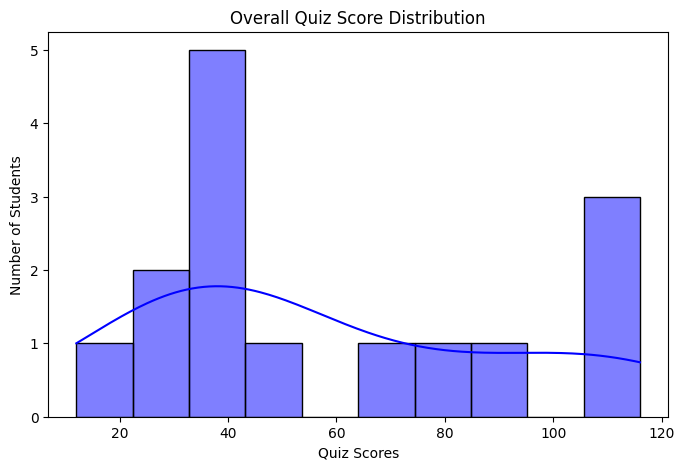

<ipython-input-7-07abbd6f8bc7>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quiz_topic', y='score', data=df, palette='coolwarm')


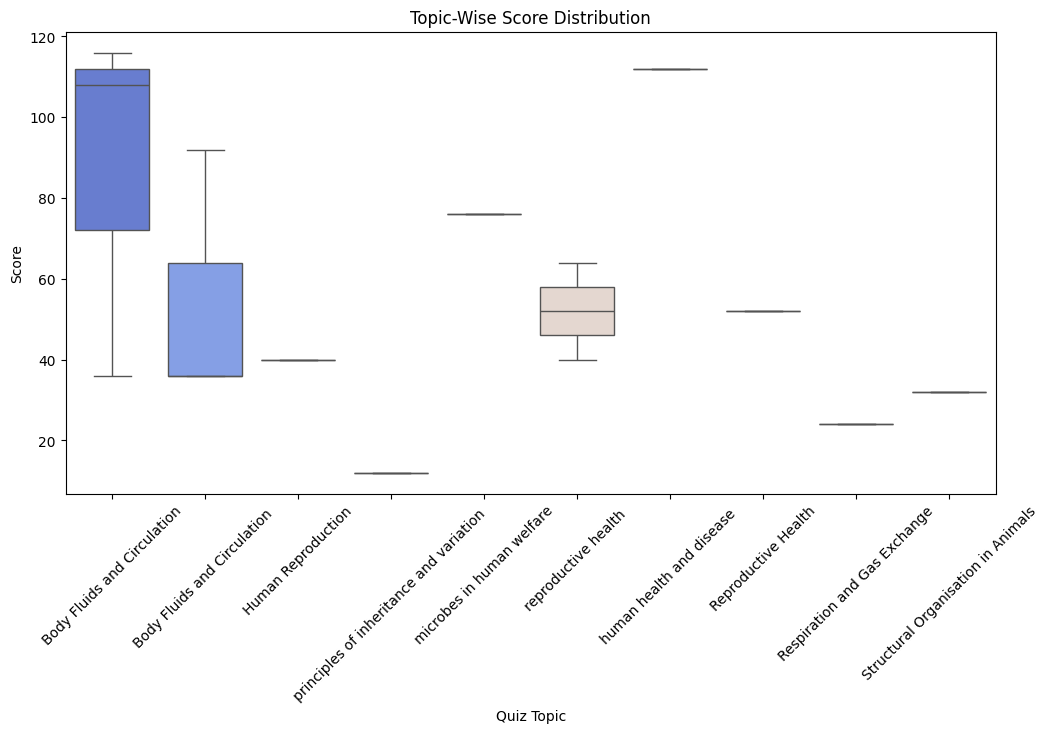

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert date columns to datetime
df['submitted_at'] = pd.to_datetime(df['submitted_at'], errors='coerce')

# ----------------------------  Student Performance Over Time (Line Chart) ---------------------------- #
def plot_student_performance(user_id):
    user_data = df[df['user_id'] == user_id].sort_values('submitted_at')

    if user_data.empty:
        print(f"No data found for user: {user_id}")
        return

    plt.figure(figsize=(10,5))
    plt.plot(user_data['submitted_at'], user_data['score'], marker='o', linestyle='-', color='b', label='Score')
    plt.xlabel("Date")
    plt.ylabel("Quiz Score")
    plt.title(f"Performance Trend for User {user_id}")
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.show()

# ----------------------------  Identifying Weak Areas (Bar Chart) ---------------------------- #
def plot_weak_topics(user_id):
    user_data = df[df['user_id'] == user_id]

    if user_data.empty:
        print(f"No data found for user: {user_id}")
        return

    topic_accuracy = user_data.groupby('quiz_topic')['accuracy'].mean().sort_values()

    plt.figure(figsize=(10,5))
    sns.barplot(x=topic_accuracy.index, y=topic_accuracy.values, palette='Reds_r')
    plt.xlabel("Quiz Topic")
    plt.ylabel("Average Accuracy (%)")
    plt.title(f"Weak Areas for User {user_id}")
    plt.xticks(rotation=45)
    plt.show()

# ----------------------------  Difficulty Level Distribution (Pie Chart) ---------------------------- #
def plot_difficulty_distribution(user_id):
    user_data = df[df['user_id'] == user_id]

    if user_data.empty:
        print(f"No data found for user: {user_id}")
        return

    difficulty_counts = user_data['difficulty_level'].value_counts()

    plt.figure(figsize=(7,7))
    plt.pie(difficulty_counts, labels=difficulty_counts.index, autopct='%1.1f%%', colors=['green', 'orange', 'red'])
    plt.title(f"Difficulty Distribution for User {user_id}")
    plt.show()

# ----------------------------  Overall Score Distribution (Histogram) ---------------------------- #
def plot_score_distribution():
    plt.figure(figsize=(8,5))
    sns.histplot(df['score'], bins=10, kde=True, color='blue')
    plt.xlabel("Quiz Scores")
    plt.ylabel("Number of Students")
    plt.title("Overall Quiz Score Distribution")
    plt.show()

# ---------------------------- Topic-Wise Score Comparison (Box Plot) ---------------------------- #
def plot_topic_score_distribution():
    plt.figure(figsize=(12,6))
    sns.boxplot(x='quiz_topic', y='score', data=df, palette='coolwarm')
    plt.xlabel("Quiz Topic")
    plt.ylabel("Score")
    plt.title("Topic-Wise Score Distribution")
    plt.xticks(rotation=45)
    plt.show()

# ---------------------------- Execute Visualizations for a Sample User ---------------------------- #
user_id = "YcDFSO4ZukTJnnFMgRNVwZTE4j42"

plot_student_performance(user_id)
plot_weak_topics(user_id)
plot_difficulty_distribution(user_id)
plot_score_distribution()
plot_topic_score_distribution()


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# Simulated previous NEET data
neet_data = pd.DataFrame({
    'score': [450, 480, 500, 550, 580, 600, 610, 620, 650, 670, 700, 710, 720, 740, 750, 770],
    'rank': [15000, 14000, 13000, 12000, 11000, 10000, 9000, 8500, 5000, 4000, 3000, 2500, 1000, 800, 500, 200]
})

# Prepare training data
X = neet_data[['score']]
y = neet_data['rank']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the model
model = LinearRegression()
model.fit(X_scaled, y)

# Function to predict rank based on quiz performance
def predict_neet_rank(user_score):
    user_score_scaled = scaler.transform([[user_score]])
    predicted_rank = model.predict(user_score_scaled)
    return max(1, int(predicted_rank[0]))  # Ensure rank is at least 1

# Predict NEET rank for the user
if not df[df['user_id'] == user_id].empty:
    latest_score = df[df['user_id'] == user_id]['score'].max()
    predicted_rank = predict_neet_rank(latest_score)
    print(f"Predicted NEET Rank for User {user_id}: {predicted_rank}")


Predicted NEET Rank for User YcDFSO4ZukTJnnFMgRNVwZTE4j42: 33595


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
